# Blood Pressure and Diabetes Prediction
This notebook focuses on predicting the likelihood of high blood pressure and diabetes using machine learning techniques.

## Load Dataset
The dataset contains clinical records of patients, including features such as age, creatinine phosphokinase levels, ejection fraction, and more. The target variables are `high_blood_pressure` and `diabetes`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE

data = pd.read_csv("heart_failure_clinical_records_dataset.csv")
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Data Preprocessing
In this section, we handle missing values and prepare the dataset for analysis. Missing values are imputed using the median to avoid bias.

In [2]:
# Check for missing values
print(data.isnull().sum())

# Handle missing values if any
data.fillna(data.median(), inplace=True)

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


## Exploratory Data Analysis (EDA)
We analyze the distribution of the target variables to understand the class imbalance and other patterns in the data.

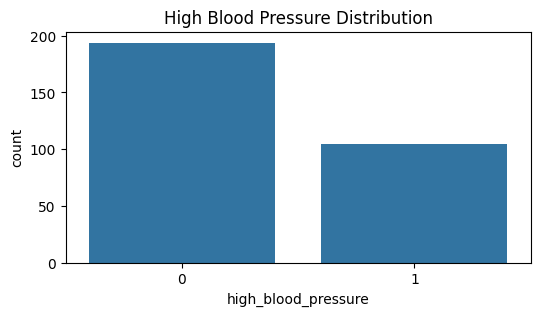

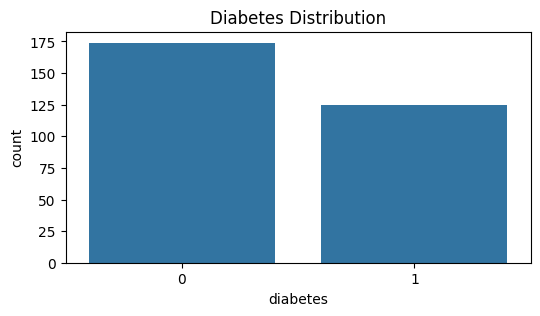

In [3]:
# Visualize the distribution of target variables
plt.figure(figsize=(6, 3))
sns.countplot(x='high_blood_pressure', data=data)
plt.title('High Blood Pressure Distribution')
plt.show()

plt.figure(figsize=(6, 3))
sns.countplot(x='diabetes', data=data)
plt.title('Diabetes Distribution')
plt.show()

## Chi-Square Test for Feature Selection
The chi-square test is used to identify the most significant features for predicting high blood pressure and diabetes.

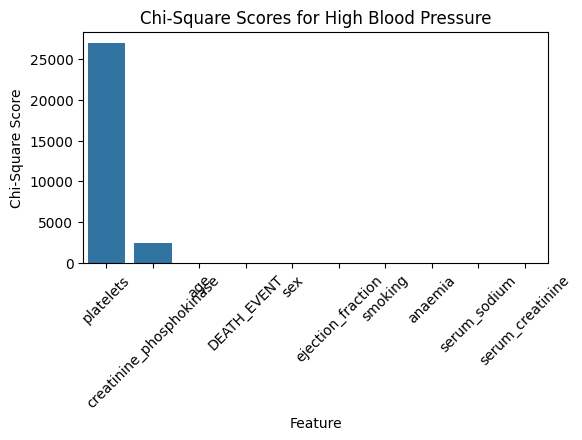

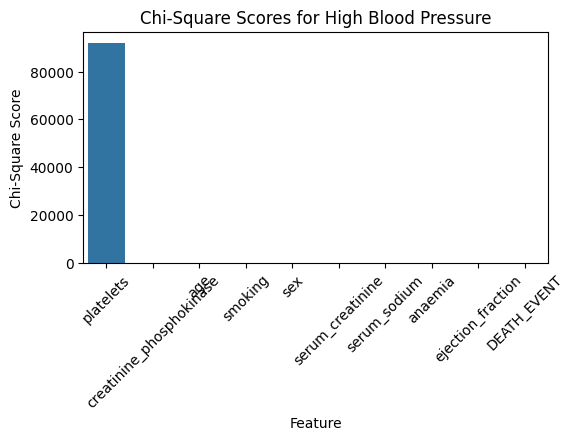

In [3]:
# Perform chi-square test
X = data.drop(['high_blood_pressure', 'diabetes', 'time'], axis=1)
y_bp = data['high_blood_pressure']
y_diabetes = data['diabetes']

chi_scores_bp = chi2(X, y_bp)
chi_scores_diabetes = chi2(X, y_diabetes)

# Create a DataFrame for visualization
chi_scores_bp_df = pd.DataFrame({'Feature': X.columns, 'Chi-Square Score': chi_scores_bp[0], 'p-value': chi_scores_bp[1]})
chi_scores_diabetes_df = pd.DataFrame({'Feature': X.columns, 'Chi-Square Score': chi_scores_diabetes[0], 'p-value': chi_scores_diabetes[1]})

# Visualize Chi-Square Scores for High Blood Pressure
plt.figure(figsize=(6, 3))
sns.barplot(x='Feature', y='Chi-Square Score', data=chi_scores_bp_df.sort_values(by='Chi-Square Score', ascending=False))
plt.title('Chi-Square Scores for High Blood Pressure')
plt.xticks(rotation=45)
plt.show()

# Visualize Chi-Square Scores for High Blood Pressure
plt.figure(figsize=(6, 3))
sns.barplot(x='Feature', y='Chi-Square Score', data=chi_scores_diabetes_df.sort_values(by='Chi-Square Score', ascending=False))
plt.title('Chi-Square Scores for High Blood Pressure')
plt.xticks(rotation=45)
plt.show()

The chi-square test reveals that `platelets` and `creatinine_phosphokinase` are significant features for both high blood pressure and diabetes predictions. However, the significance of `creatinine_phosphokinase` is more pronounced for diabetes.

## Train-Test Split
Split the dataset into training and testing sets for both high blood pressure and diabetes predictions.

In [26]:
# Define features and target variables
X = data.drop(['high_blood_pressure', 'diabetes', 'time'], axis=1)
y_bp = data['high_blood_pressure']
y_diabetes = data['diabetes']

# Split data for high blood pressure
X_train_bp, X_test_bp, y_train_bp, y_test_bp = train_test_split(
    X, y_bp, test_size=0.2, random_state=42, stratify=y_bp
)

# Split data for diabetes
X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(
    X, y_diabetes, test_size=0.2, random_state=42, stratify=y_diabetes
)

## High Blood Pressure Prediction
This section focuses on predicting high blood pressure using multiple models and evaluating their performance.

In [27]:
# Check for imbalance
print("Class distribution in training set:")
print(y_train_bp.value_counts())  # Check for imbalance in the training set

# Apply SMOTE if necessary
smote = SMOTE(random_state=42)
X_resampled_bp, y_resampled_bp = smote.fit_resample(X_train_bp, y_train_bp)


Class distribution in training set:
high_blood_pressure
0    155
1     84
Name: count, dtype: int64


### Model Training for High Blood Pressure

In [28]:
# Train models for high blood pressure
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=5000)
}

results_bp = []
for name, model in models.items():
    model.fit(X_resampled_bp, y_resampled_bp)
    y_pred = model.predict(X_test_bp)
    report = classification_report(y_test_bp, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test_bp, y_pred)
    results_bp.append((name, accuracy, report['1']['precision'], report['1']['recall'], report['1']['f1-score']))

results_bp_df = pd.DataFrame(results_bp, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
results_bp_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.633333,0.466667,0.333333,0.388889
1,XGBoost,0.616667,0.454545,0.476190,0.465116
2,SVC,0.433333,0.333333,0.619048,0.433333
3,Logistic Regression,0.650000,0.500000,0.476190,0.487805


## Diabetes Prediction
This section focuses on predicting diabetes using the same models and evaluation metrics.

In [29]:
# Check for imbalance
print("Class distribution in training set:")
print(y_train_diabetes.value_counts())

# Apply SMOTE if necessary
X_resampled_diabetes, y_resampled_diabetes = smote.fit_resample(X_train_diabetes, y_train_diabetes)

Class distribution in training set:
diabetes
0    139
1    100
Name: count, dtype: int64


### Model Training for Diabetes

In [30]:
# Train models for diabetes
results_diabetes = []
for name, model in models.items():
    model.fit(X_resampled_diabetes, y_resampled_diabetes)
    y_pred = model.predict(X_test_diabetes)
    accuracy = accuracy_score(y_test_diabetes, y_pred)
    precision = precision_score(y_test_diabetes, y_pred)
    recall = recall_score(y_test_diabetes, y_pred)
    f1 = classification_report(y_test_diabetes, y_pred, output_dict=True)['1']['f1-score']
    results_diabetes.append((name, accuracy, precision, recall, f1))

results_diabetes_df = pd.DataFrame(results_diabetes, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
results_diabetes_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.533333,0.451613,0.56,0.500000
1,XGBoost,0.550000,0.468750,0.60,0.526316
2,SVC,0.500000,0.407407,0.44,0.423077
3,Logistic Regression,0.550000,0.461538,0.48,0.470588


## Model Performance Summary
The following chart compares the recall scores of different models for high blood pressure and diabetes predictions.

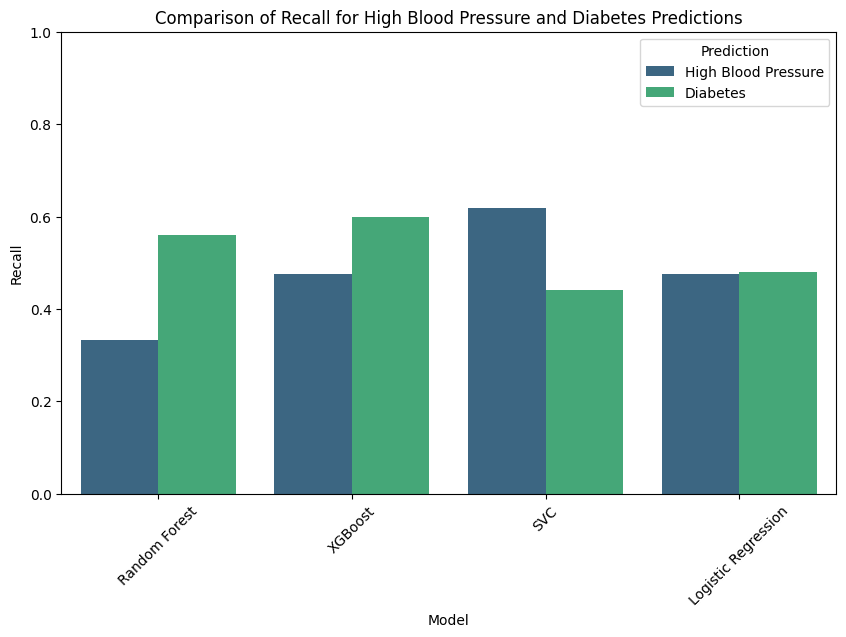

In [31]:
# Prepare data for visualization
comparison_df = pd.concat([
    results_bp_df[['Model', 'Recall']].assign(Prediction='High Blood Pressure'),
    results_diabetes_df[['Model', 'Recall']].assign(Prediction='Diabetes')
])

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x='Model', y='Recall', hue='Prediction', palette='viridis')
plt.title('Comparison of Recall for High Blood Pressure and Diabetes Predictions')
plt.ylabel('Recall')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(title='Prediction')
plt.xticks(rotation=45)
plt.show()

## Conclusion
This notebook demonstrates the prediction of high blood pressure and diabetes using Random Forest, XGBoost, SVC, and Logistic Regression. Logistic Regression achieved the highest recall for both conditions, making it the most reliable model for identifying critical cases.

When compared to the Death_Event analysis, the models for high blood pressure and diabetes showed similar trends in feature importance, such as the significance of serum creatinine and ejection fraction. However, the Death_Event model achieved slightly better recall with Random Forest and XGBoost, highlighting the importance of tailored feature selection for each prediction task.

Overall, the results emphasize the need for balanced datasets and careful feature engineering to improve recall, especially in medical predictions where missing critical cases can have severe consequences.